In [79]:
%load_ext autoreload
%autoreload 3
from Probe import  probe_shapelet
import numpy as np
import pandas as pd
import utils
from utils import *
import warnings
import torch
import pickle
import matplotlib.pyplot as plt
warnings.filterwarnings("ignore")

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [3]:
device = 'cuda' if torch.cuda.is_available else 'cpu'

In [1]:
from tsai.models.FCN import FCN
model_path = 'models/GunPoint/'
model = FCN(c_in=1, c_out=2)
state_dict = torch.load(f'{model_path}/weight.pt',map_location='cuda:1')
model.load_state_dict(state_dict)
model.eval()

train_x, test_x, train_y, test_y, enc1 = utils.read_UCR_UEA('GunPoint', None)

instance_length = train_x.shape[-1]

with open(f'shapelets/GunPoint/RSTF.pkl', 'rb') as f:
    ST_attribution = pickle.load(f)
# pick the first Shapelet
info_gain, shapelet_length, start_pos, dimension, inst_index, shapelet_class, z_norm_shapelet = ST_attribution.shapelets[0]

NameError: name 'torch' is not defined

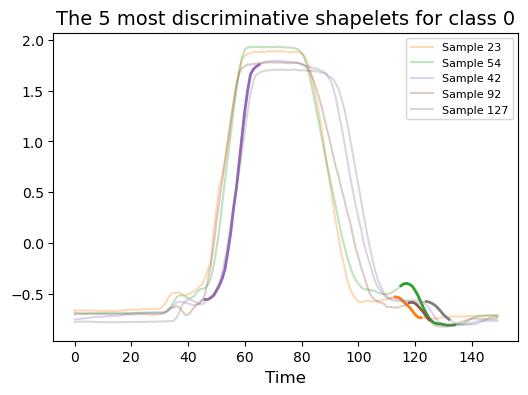

In [322]:
# train_x, test_x, train_y, test_y, enc1 = utils.read_UCR_UEA('GunPoint', None)
# from pyts.transformation import ShapeletTransform
# st = ShapeletTransform(window_sizes=[8,9,10,20,30],
#                        random_state=42, sort=True)
# X_new = st.fit_transform(test_x.reshape(test_x.shape[0],test_x.shape[-1]), np.argmax(test_y, axis=1))
# test_y_one_hot = np.argmax(test_y, axis=1)
 
# plt.figure(figsize=(6, 4))
# count = 0
# for i, index in enumerate(st.indices_):
#     idx, start, end = index
#     if count > 4:
#         break
#     if test_y_one_hot[idx] == 0:
#         plt.plot(test_x.reshape(test_x.shape[0],test_x.shape[-1])[idx], color='C{}'.format(i),
#                  label='Sample {}'.format(idx),alpha=0.3)
#         plt.plot(np.arange(start, end), test_x.reshape(test_x.shape[0],test_x.shape[-1])[idx, start:end],
#                  lw=2, color='C{}'.format(i))
#         count +=1
# plt.xlabel('Time', fontsize=12)
# plt.title('The 5 most discriminative shapelets for class 0', fontsize=14)
# plt.legend(loc='best', fontsize=8)
# plt.show()

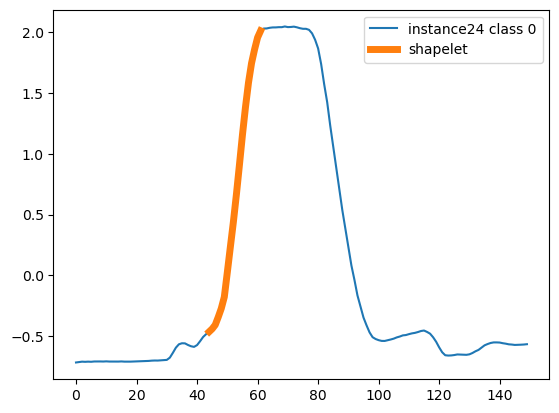

In [4]:
plt.plot(train_x[inst_index].flatten(),label=f'instance{inst_index} class {shapelet_class}')
plt.plot(np.arange(start_pos,start_pos+shapelet_length),train_x[inst_index,:,start_pos:start_pos+shapelet_length].flatten(),
         linewidth=5,label='shapelet')
plt.legend()

In [5]:
shapelet = train_x[2,:,90:107].flatten()
# shapelet = z_norm_process_shapelet(shapelet)

In [151]:
pdata = get_pdata(shapelet=shapelet, selected_datasets=utils.selected_uni, inst_length=instance_length, 
                   num_shapelet=1, is_add=False, repeat_max=100,
                       is_z_norm=True, save_dir='probe/GunPoint_implet')

dealing with ECG200: (100, 1, 96)
dealing with Beef: (30, 1, 470)
dealing with ElectricDevices: (8926, 1, 96)
dealing with Earthquakes: (322, 1, 512)
dealing with Wafer: (1000, 1, 152)
dealing with PowerCons: (180, 1, 144)
dealing with NonInvasiveFetalECGThorax1: (1800, 1, 750)
dealing with ECG5000: (500, 1, 140)
dealing with HandOutlines: (1000, 1, 2709)
dealing with CBF: (30, 1, 128)
dealing with FordA: (3601, 1, 500)
dealing with TwoPatterns: (1000, 1, 128)
dealing with UWaveGestureLibraryAll: (896, 1, 945)
dealing with Chinatown: (20, 1, 24)
dealing with Yoga: (300, 1, 426)
dealing with DistalPhalanxOutlineCorrect: (600, 1, 80)
dealing with Computers: (250, 1, 720)
dealing with ShapesAll: (600, 1, 512)
dealing with Strawberry: (613, 1, 235)


In [157]:
with open('probe/GunPoint_implet/pdata.pkl','rb') as f:
    pdata = pickle.load(f)

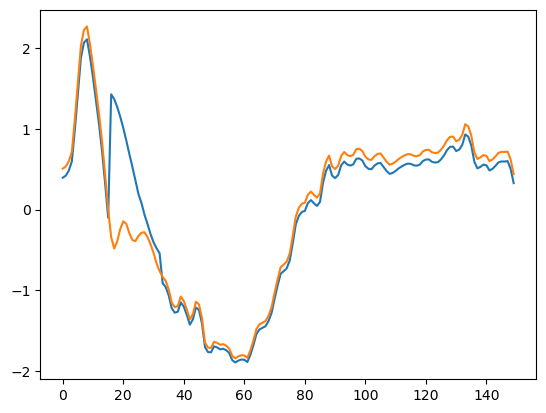

In [158]:
plt.plot(pdata['pdata_ws'][0].flatten(),label='with shapelet')
plt.plot(pdata['pdata_wos'][0].flatten(),label='without shapelet')

In [159]:
pdata = np.concatenate((pdata['pdata_ws'],pdata['pdata_wos']), axis=0)

In [179]:
3360/2

1680.0

In [160]:
print(pdata.shape)

(3360, 1, 150)


In [190]:
results = probe_shapelet(dataset=train_x, labels=train_y, pdata=pdata, model=model, 
                         shapelet=shapelet, pos=start_pos, device='cuda:1',save_path='probe/GunPoint_implet',
                         shapelet_labels=[None, [0]*1680+[1]*1680],
                         is_threshold_info_gain=True)

(50, 128) (3360, 128)
Training Accuracy = 0.79
Testing Accuracy = 0.79
----------------------
Accuracy = 0.48


In [192]:
with open('probe/GunPoint_implet/probe_latent_label.pkl', 'rb') as f:
    probe_latent_label = pickle.load(f)
dataset_s_distances = probe_latent_label['dataset_s_distances']
pdata_s_distances = probe_latent_label['pdata_s_distances']
# best_threshold = probe_latent_label['best_threshold']
dataset_s_label = probe_latent_label['dataset_s_label']
pdata_s_label = probe_latent_label['pdata_s_label']
dataset_latent = probe_latent_label['dataset_latent']
pdata_latent = probe_latent_label['pdata_latent']

In [174]:
best_threshold

0.0023637299576189114

In [193]:
print(np.count_nonzero([i==1 for i in pdata_s_label]))
print(np.count_nonzero([i==0 for i in pdata_s_label]))

print(np.count_nonzero([i==1 for i in dataset_s_label]))
print(np.count_nonzero([i==0 for i in dataset_s_label]))

1680
1680
16
34


In [194]:
with open('probe/GunPoint_implet/results.pkl', 'rb') as f:
    results = pickle.load(f)
pred_train = results['pred_train']
pred_test = results['pred_test']
dataset_s_pred = results['dataset_s_pred']
print(np.count_nonzero([i==0 for i in dataset_s_pred]))
print(np.count_nonzero([i==1 for i in dataset_s_pred]))

10
40


In [195]:
len(dataset_s_label)

50

In [196]:
label = np.zeros(len(pdata_s_label)+len(dataset_s_label),dtype=np.uint8)
for i in range(len(pdata_s_label)+len(dataset_s_label)):
    if i<3360 and pdata_s_label[i]==0:
        label[i] = 0
    elif i<3360 and pdata_s_label[i]==1:
        label[i] = 1 
    elif i>=3360 and dataset_s_label[i-3360]==0:
        label[i] = 2
    elif i>=3360 and dataset_s_label[i-3360]==1:
        label[i] = 3

In [197]:
dataset_latent.shape

(50, 128)

In [207]:
from sklearn.manifold import TSNE
tsne = TSNE(perplexity=20)
latent_vis = tsne.fit_transform(np.concatenate((pdata_latent,dataset_latent)))

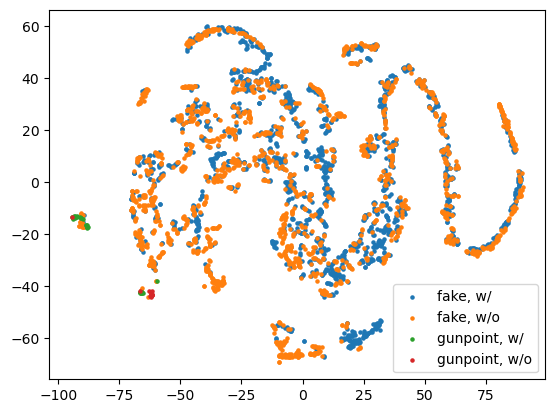

In [208]:
plt.scatter(latent_vis[label == 0, 0], latent_vis[label == 0, 1], label='fake, w/', s=5)
plt.scatter(latent_vis[label == 1, 0], latent_vis[label == 1, 1], label='fake, w/o', s=5)
plt.scatter(latent_vis[label == 2, 0], latent_vis[label == 2, 1], label='gunpoint, w/', s=5, color=plt.get_cmap('tab10')(2))
plt.scatter(latent_vis[label == 3, 0], latent_vis[label == 3, 1], label='gunpoint, w/o', s=5, color=plt.get_cmap('tab10')(3))

plt.legend()
plt.savefig('probe/GunPoint_implet/tsne.png')

In [ ]:
probe_shapelet(dataset=train_x, labels=train_y, pdata=test_x, model=model, 
                         shapelet=shapelet, pos=start_pos, device='cuda:1')

# 12/01/2024 blending shapelet sanity check

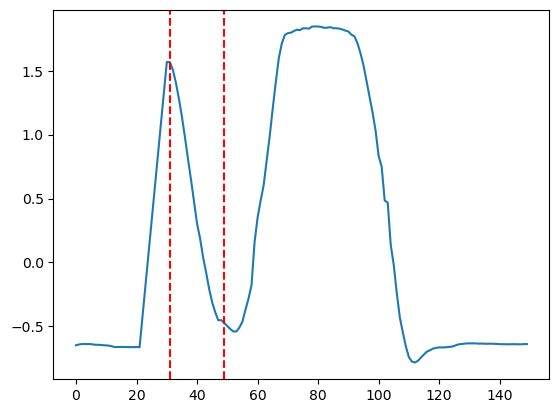

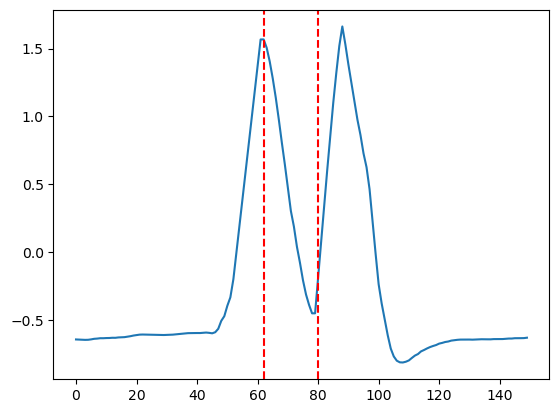

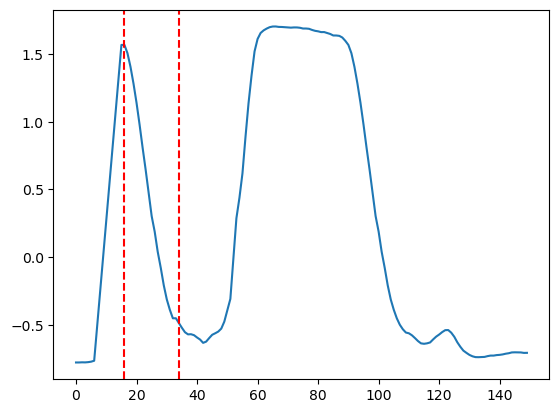

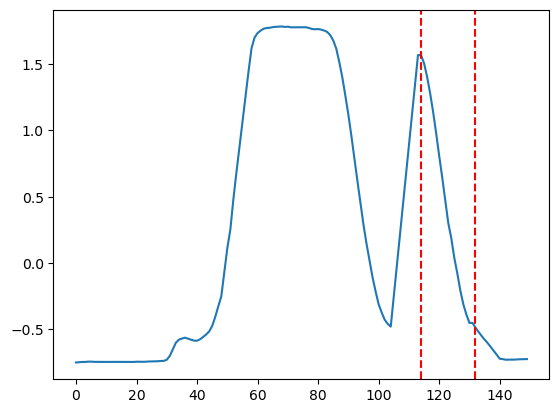

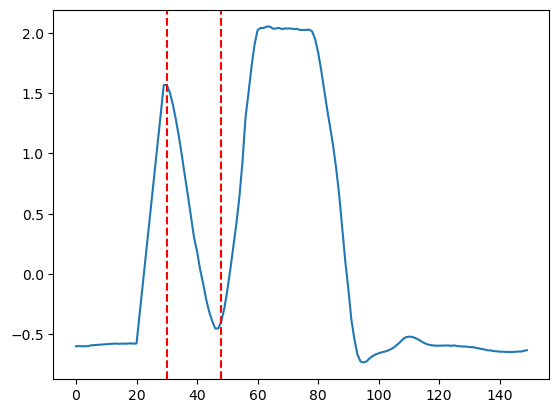

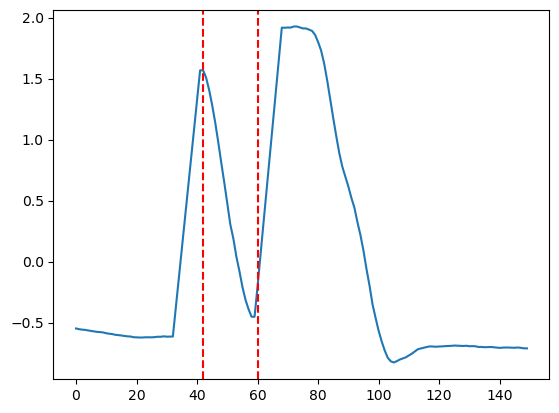

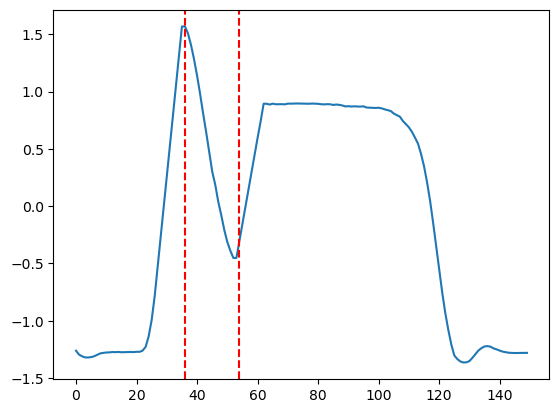

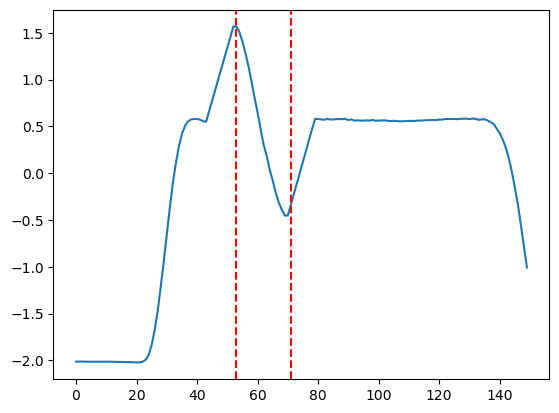

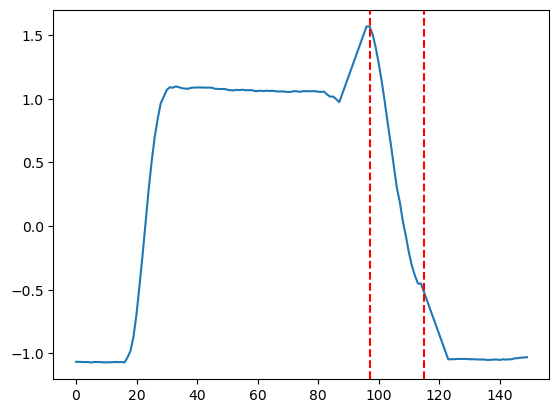

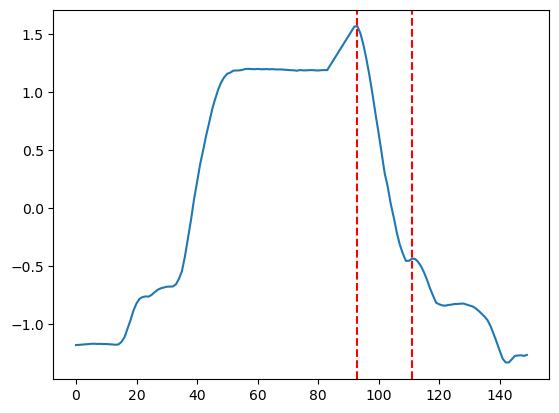

In [7]:
c1,startings =insert_shapelet(train_x,shape1=shapelet,is_blending=True,blend_length=10)
for i in range(10):
    plt.plot(c1[i].flatten())
    plt.axvline(startings[i],linestyle='--',color='r')
    plt.axvline(startings[i]+18,linestyle='--',color='r')
    plt.show()

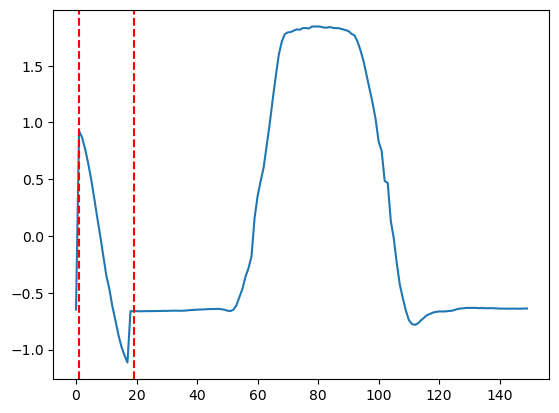

In [8]:
c1,startings =insert_shapelet(train_x,shape1=shapelet,is_blending=False)
plt.plot(c1[0].flatten())
plt.axvline(startings[0],linestyle='--',color='r')
plt.axvline(startings[0]+18,linestyle='--',color='r')

[3, 75]


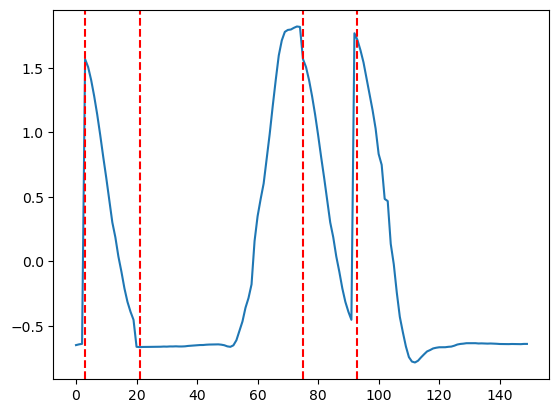

[80, 102]


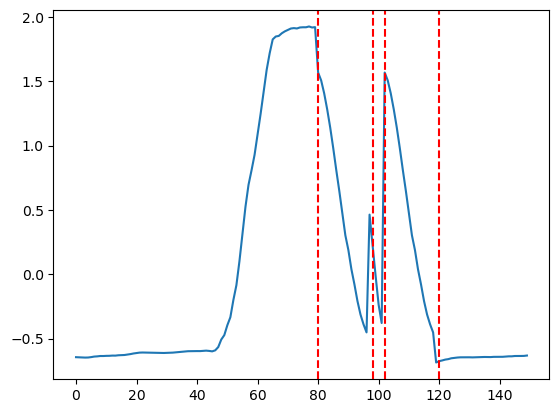

[49, 131]


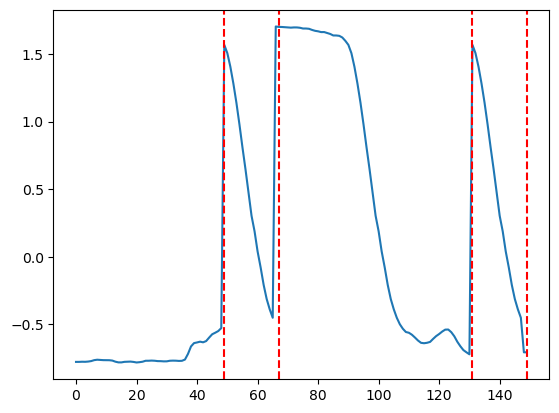

In [16]:
c1, startings = data_given_env_multiple_shapelet(train_x, shape1=shapelet, num_shapelet=2, is_add=False, is_blending=False, blend_length=5)

for i in range(3):
    plt.plot(c1[i].flatten())
    for j in startings[i]:
        plt.axvline(j,linestyle='--',color='r')
        plt.axvline(j+18,linestyle='--',color='r')
    plt.show()



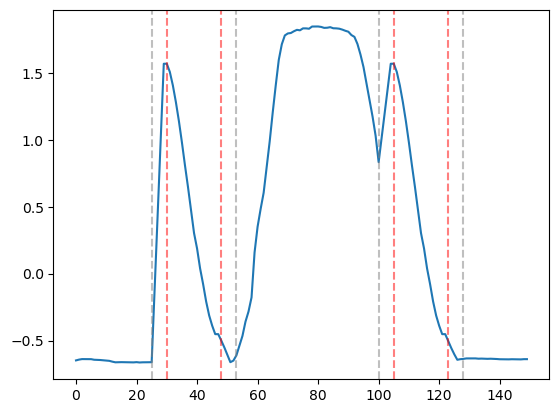

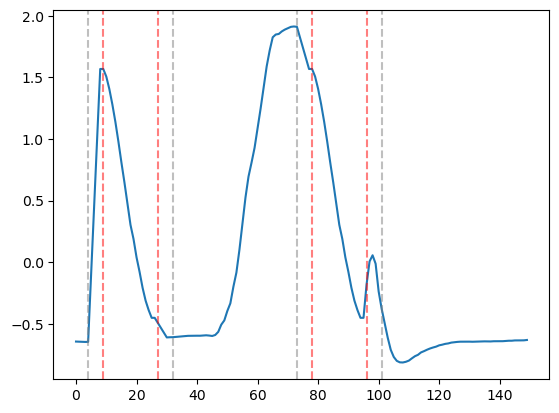

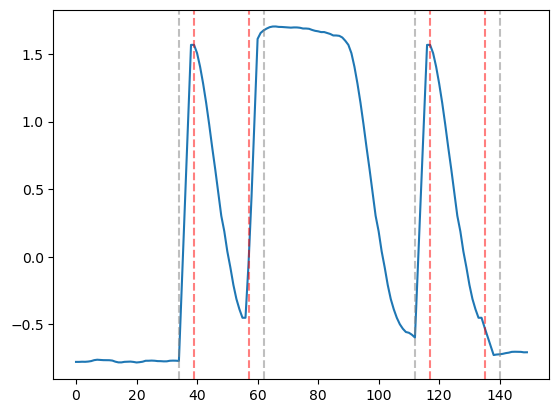

In [14]:
c1, startings = data_given_env_multiple_shapelet(train_x, shape1=shapelet, num_shapelet=2, is_add=False, is_blending=True, blend_length=5)

for i in range(3):
    plt.plot(c1[i].flatten())
    for j in startings[i]:
        plt.axvline(j-5,linestyle='--',color='grey',alpha=0.5)
        plt.axvline(j,linestyle='--',color='r',alpha=0.5)
        plt.axvline(j+18,linestyle='--',color='r',alpha=0.5)
        plt.axvline(j+23,linestyle='--',color='grey',alpha=0.5)
    plt.show()

# 12/01 best insert

In [29]:
c1,startings =insert_shapelet(train_x,shape1=shapelet,is_blending=False,blend_length=None,is_best_insert=True)

-0.15073959999999986
-0.4531562
-0.16171859999999993
-0.05334929999999982
0.4636526000000001
-0.39157019999999987
-1.0219519099999999
-0.9857365399999999
-0.7952314599999999
-0.44396599999999986
-0.17468059999999985
-0.5330021999999999
-0.8909351999999999
-0.4919217
0.4556579000000003
-0.37804819999999983
-0.3601626
0.26879620000000015
-0.29757449999999985
-0.6255007599999999
-0.07017849999999992
-0.6529296199999999
-0.411751
-1.01523809
0.46202889999999996
-0.7521463899999999
-0.5071327999999999
-0.36219159999999984
-0.6677755499999999
-0.6926938699999999
-0.15472789999999992
-0.9417188899999999
-0.4914915999999998
-0.07255020000000001
-0.17224779999999984
0.3855396
-0.9871036799999999
0.4352640000000001
-0.9368798199999999
-0.8609315099999999
0.10649030000000015
-0.4536445
-0.38555649999999986
-0.5576185999999999
-0.6882233899999999
0.25880000000000014
0.02289490000000005
0.15785250000000017
-0.1746315999999999
-1.02412414


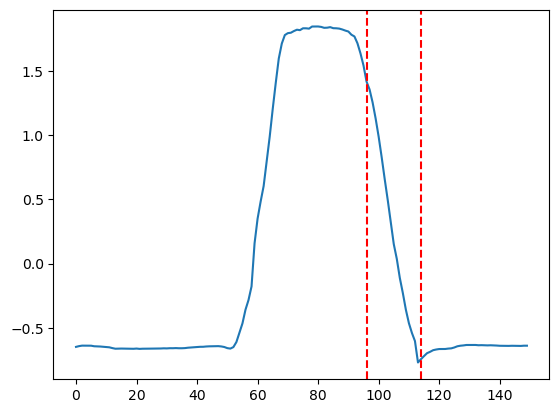

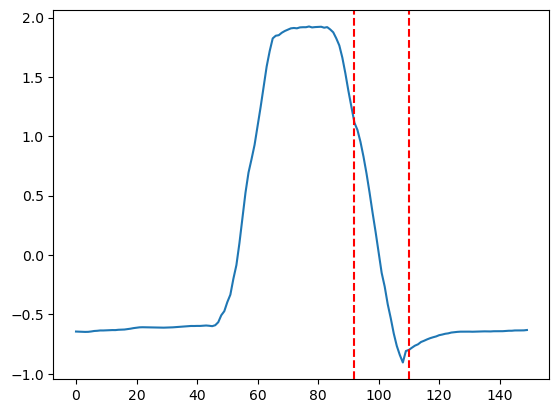

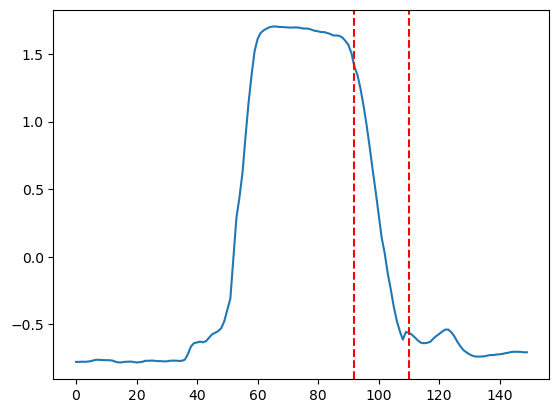

In [30]:
for i in range(3):
    plt.plot(c1[i].flatten())
    plt.axvline(startings[i][0],linestyle='--',color='r')
    plt.axvline(startings[i][0]+18,linestyle='--',color='r')
    plt.show()

# 12/07 dataset with cheating marks

In [6]:
selected_uni

['ECG200',
 'Beef',
 'ElectricDevices',
 'Earthquakes',
 'Wafer',
 'PowerCons',
 'NonInvasiveFetalECGThorax1',
 'ECG5000',
 'GunPoint',
 'HandOutlines',
 'CBF',
 'FordA',
 'TwoPatterns',
 'UWaveGestureLibraryAll',
 'Chinatown',
 'Yoga',
 'DistalPhalanxOutlineCorrect',
 'Computers',
 'ShapesAll',
 'Strawberry']

In [372]:
shapelet = np.sin(np.linspace(0,np.pi,9))*0.2
inst_length = 150

In [391]:
selected_datasets = selected_uni
if 'GunPoint' in selected_datasets:
    selected_datasets.remove('GunPoint')
moti_train_data = get_pdata(
        shapelet, selected_datasets, inst_length, num_shapelet=1, is_add=False,
        repeat_max=100, is_z_norm=True, is_blending=False, blend_length=5, insert_fixed_starting = None,
        is_best_insert=True, save_dir='models/simu10_motivation_cheat_2/train.pkl'
        )

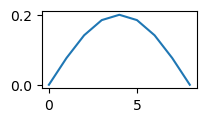

In [435]:
plt.figure(figsize=(2,1))
plt.plot(shapelet)

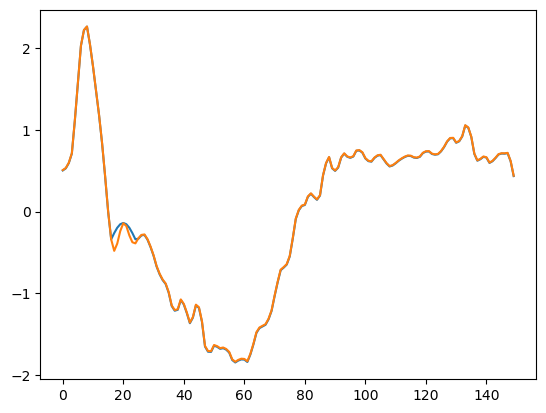

In [392]:
plt.plot(moti_train_data['pdata_ws'][0].flatten())
plt.plot(moti_train_data['pdata_wos'][0].flatten())

In [394]:
moti_train_data = pickle_load_from_file('models/simu10_motivation_cheat_2/train.pkl')
train_y = np.array([0]*len(moti_train_data['pdata_ws'])+[1]*len(moti_train_data['pdata_wos']))
train_x = np.concatenate((moti_train_data['pdata_ws'],moti_train_data['pdata_wos']))

_, test_x, _, test_y, enc1 = utils.read_UCR_UEA('GunPoint', None)
test_y = np.argmax(test_y, axis=1)

test_x_c0 = test_x[test_y==0].copy()
test_x_c1 = test_x[test_y==1].copy()
starting = 10
test_x_c0, _ = insert_fixed(test_x_c0, shapelet, starting, is_add=False, is_blending=False, blend_length=5, shift=True)


test_y = np.array([0]*len(test_x_c0)+[1]*len(test_x_c1))
test_x = np.concatenate((test_x_c0,test_x_c1))
print(train_x.shape, test_x.shape)

(3360, 1, 150) (150, 1, 150)


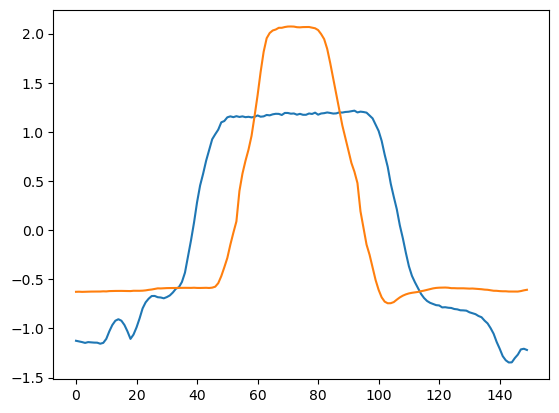

In [396]:
plt.plot(test_x_c0[0].flatten())
plt.plot(test_x_c1[0].flatten())

In [397]:
enc1 = sklearn.preprocessing.OneHotEncoder(sparse_output=False).fit(train_y.reshape(-1, 1))
train_y = enc1.transform(train_y.reshape(-1, 1))
test_y = enc1.transform(test_y.reshape(-1, 1))
data = {
    'train_x': train_x,
    'test_x': test_x,
    'train_y': train_y,
    'test_y': test_y
}

model_dataset_path = 'models/simu10_motivation_cheat_2'

if not os.path.exists(model_dataset_path):
    os.makedirs(model_dataset_path)

with open(model_dataset_path+'/data.pkl', 'wb') as f:
    pickle.dump(data, f)

In [398]:
train_y.shape

(3360, 2)

In [399]:
train_x.shape

(3360, 1, 150)

In [400]:
model = FCN(c_in=1, c_out=2)
train_loader, test_loader = generate_loader(train_x, test_x, train_y, test_y, batch_size_train=128, batch_size_test=32)
fit(model, train_loader, device=device, num_epochs=100)
torch.save(model.state_dict(), f'{model_dataset_path}/weight.pt')

train_preds, acc = get_pred_with_acc(model, train_x, train_y, device='cuda')
print(f'training acc:{acc:.3f}')

test_preds, acc = get_pred_with_acc(model, test_x, test_y, device='cuda')
np.save(f'{model_dataset_path}/test_preds.npy', np.array(test_preds))
acc = accuracy_score(ground_truth, test_preds)
print(f'testing acc:{acc:.3f}')
a = classification_report(ground_truth, test_preds, output_dict=True)
dataframe = pd.DataFrame.from_dict(a)
dataframe.to_csv(f'{model_dataset_path}/classification_report.csv', index=False)

100%|█████████████████████████████████████████████████████████████████████████████████| 100/100 [00:09<00:00, 10.92it/s]

training acc:0.979
testing acc:0.980


In [401]:
train_x.shape

(3360, 1, 150)

In [447]:
3360/2

1680.0

IntegratedGradients


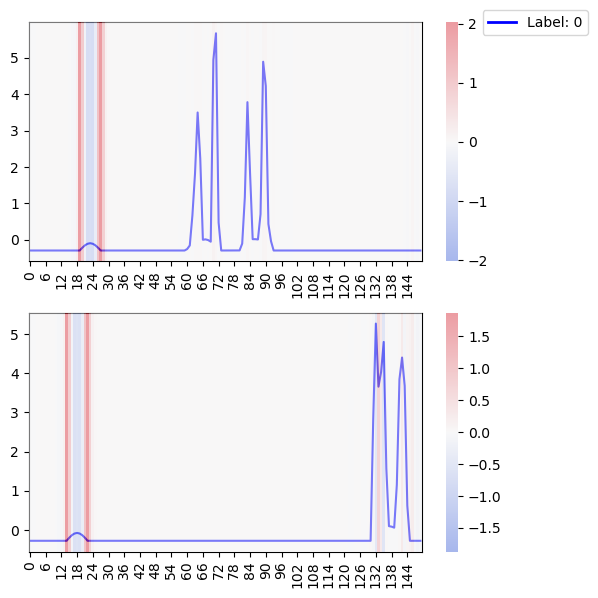

In [454]:
startings = moti_train_data['startings']
for xai_name in ['IntegratedGradients']:
    print(xai_name)
    # attr_gp, _= get_attr(model,train_x,None,None,
    #                         save_dir=None,
    #                         xai_name=xai_name,target_class=None)
    # attr_path = f'attributions/GunPoint_cheat_class_{target_class}/{xai_name}/exp.pkl'
    # attr = pickle_load_from_file(attr_path)
    # attr_gp = attr['attributions']
    # plot_indices = np.array([1680+5,1680+12])
    plot_indices = np.array([200,212])
    plot_multiple_images_with_attribution(train_x[plot_indices], train_y[plot_indices], 2, figsize=(6,6), 
                                  use_attribution=True,
                                  attributions=attr_gp[plot_indices],
                                  normalize_attribution=True,
                                  save_path=None,
                                  test_y=train_preds[plot_indices],
                                  # startings=[startings[i] for i in range(len(startings)) if i in plot_indices],
                                  # shapelet_length=9
                                 )

IntegratedGradients


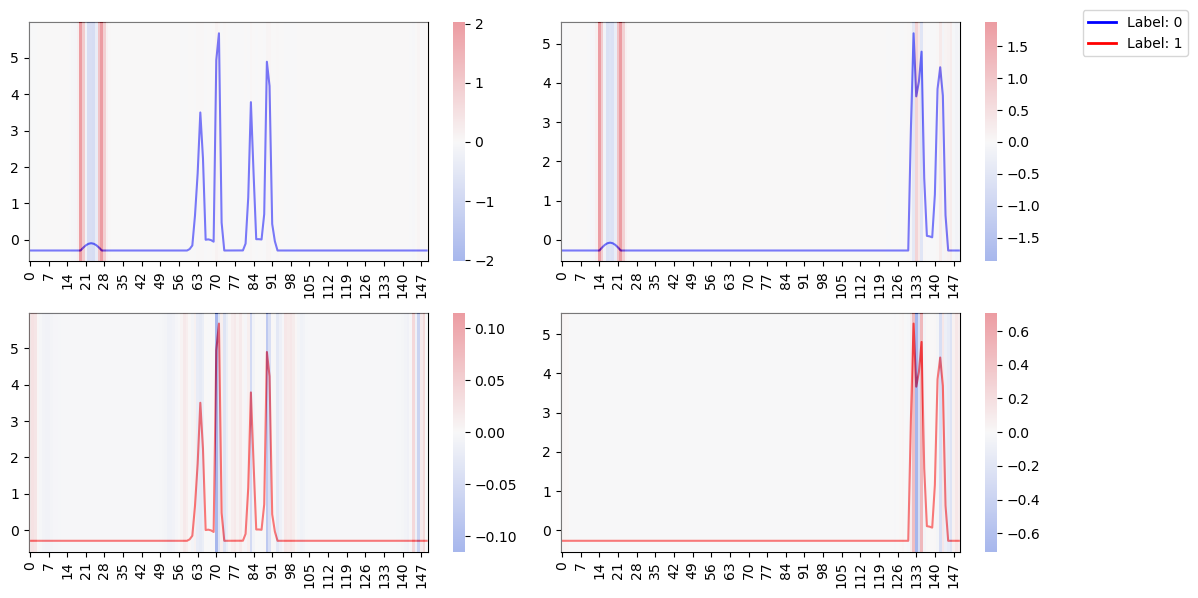

In [459]:
startings = moti_train_data['startings']
for xai_name in ['IntegratedGradients']:
    print(xai_name)
    attr_gp, _= get_attr(model,train_x,None,None,
                            save_dir=None,
                            xai_name=xai_name,target_class=None)
    # attr_path = f'attributions/GunPoint_cheat_class_{target_class}/{xai_name}/exp.pkl'
    # attr = pickle_load_from_file(attr_path)
    # attr_gp = attr['attributions']
    plot_indices = np.array([200,212,1680+200,1680+212])
    # plot_indices = np.array([5,12])
    plot_multiple_images_with_attribution(train_x[plot_indices], train_y[plot_indices], 4, figsize=(12,6), 
                                  use_attribution=True,
                                  attributions=attr_gp[plot_indices],
                                  normalize_attribution=True,
                                  save_path=None,
                                  test_y=train_preds[plot_indices],
                                  # startings=[startings[i] for i in range(len(startings)) if i in plot_indices],
                                  # shapelet_length=9
                                 )

IntegratedGradients


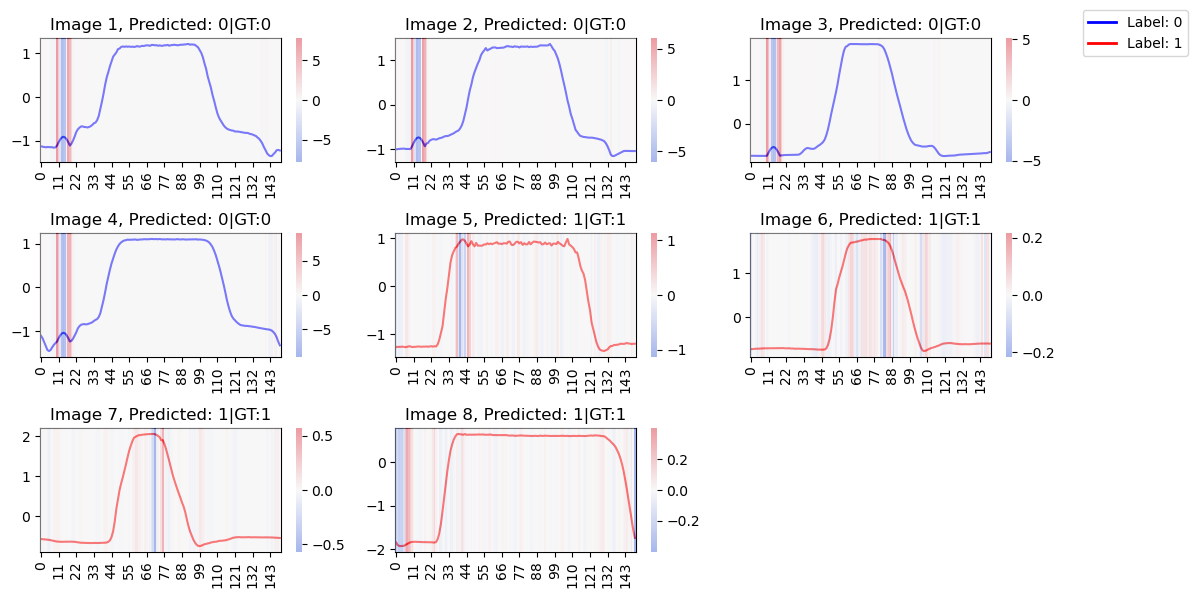

In [456]:
for xai_name in ['IntegratedGradients']:
    print(xai_name)
    target_class = None
    attr_path = f'attributions/GunPoint_cheat_class_{target_class}/{xai_name}/exp.pkl'
    attr_gp, _= get_attr(model,test_x,None,None,
                            save_dir=attr_path,
                            xai_name=xai_name,target_class=target_class)

    attr = pickle_load_from_file(attr_path)
    attr_gp = attr['attributions']
    plot_indices = np.array([0,1,2,3,-1,-2,-3,-4])
    plot_multiple_images_with_attribution(test_x[plot_indices], test_y[plot_indices], 8, figsize=(12,6), 
                                  use_attribution=True,
                                  attributions=attr_gp[plot_indices],
                                  normalize_attribution=True,
                                  save_path=None,
                                  test_y = test_preds[plot_indices],
                                  # startings=[[10]]*8,
                                  # shapelet_length=9,
                                  is_title=True,
                                
                                 )

In [420]:
c0_indices = []
for i, index in enumerate(st.indices_):
    idx, start, end = index
    if test_y_one_hot[idx] == 0:
        c0_indices.append([idx, start, end])



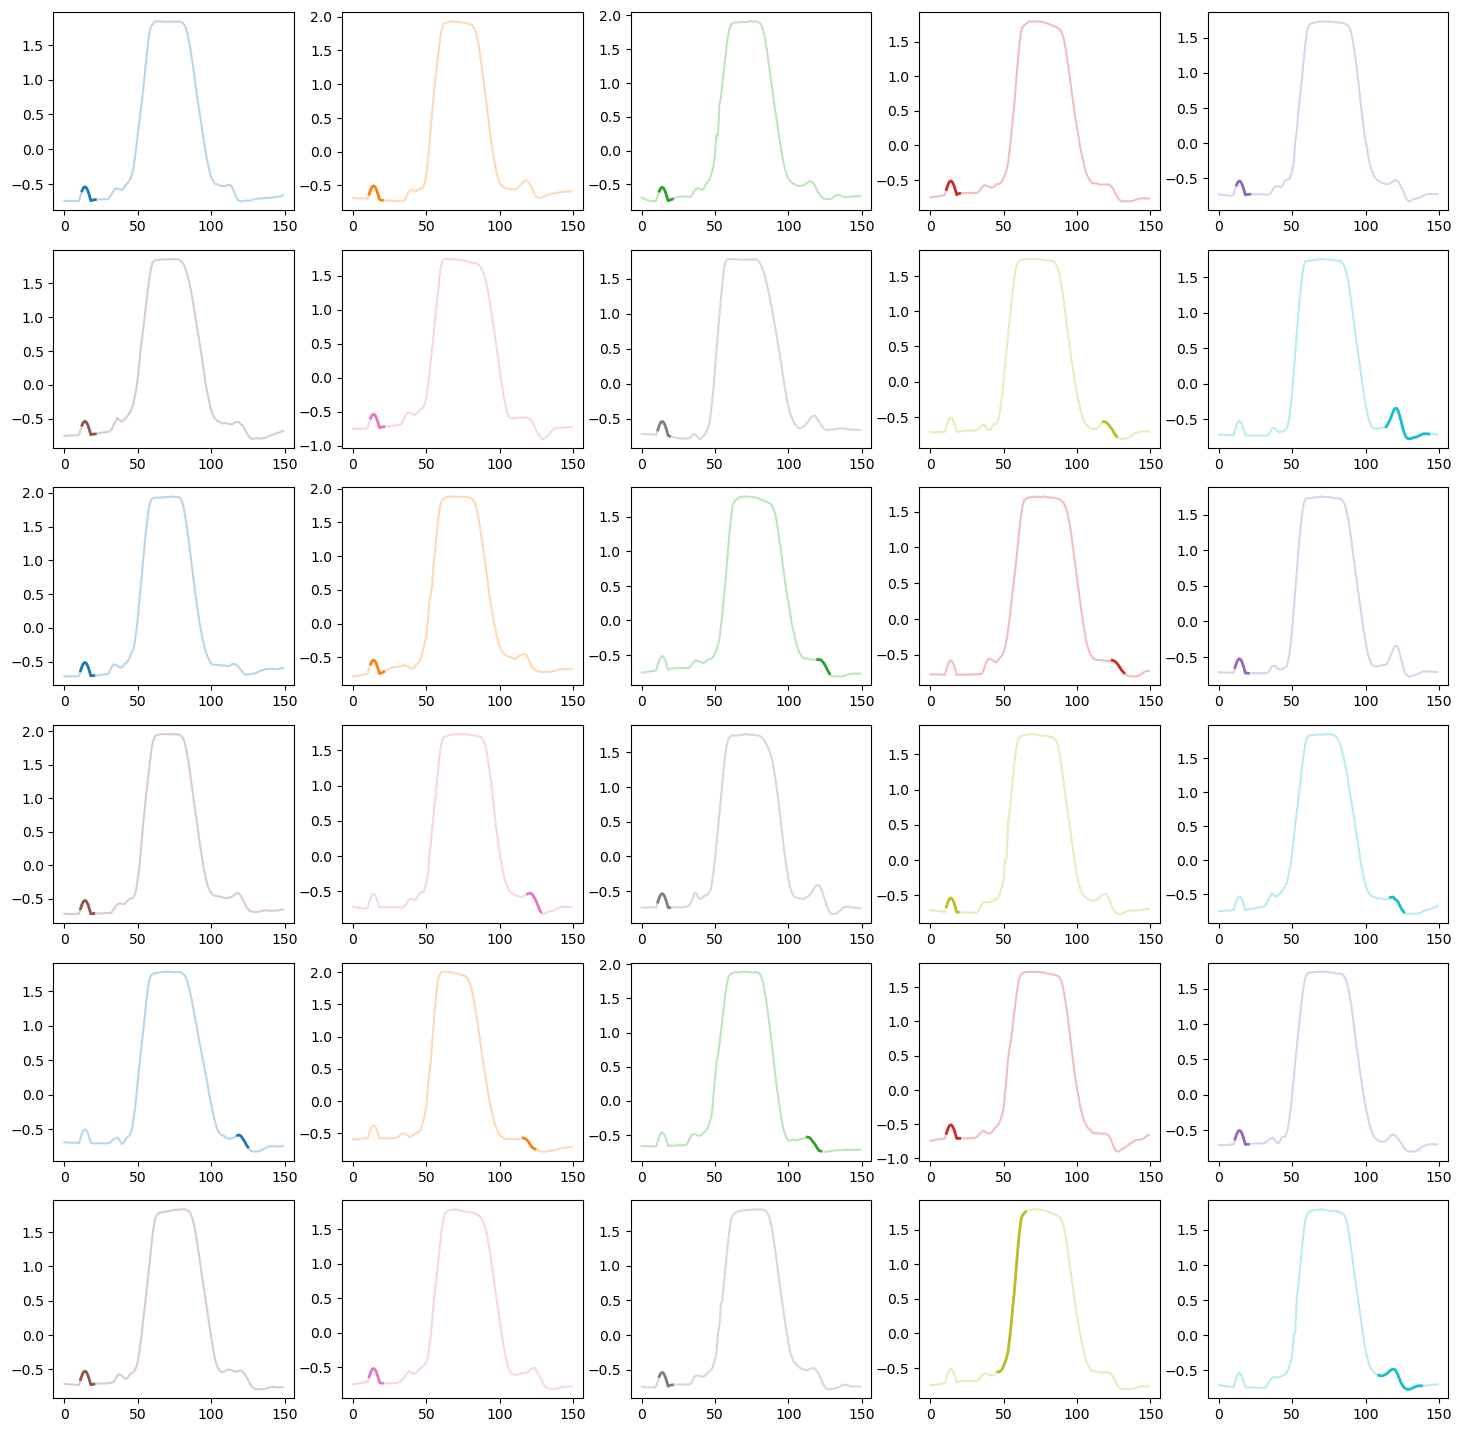

In [430]:
n = len(c0_indices[:30])
num_rol_col = math.ceil(math.sqrt(n))
shape = (num_rol_col, math.ceil(n / num_rol_col))
figsize = (num_rol_col * 3, num_rol_col * 3)

fig, axes = plt.subplots(shape[0], shape[1], figsize=figsize)
axes = axes.flatten()

for i in range(n):
    idx, start, end = c0_indices[i]
    axes[i].plot(test_x.reshape(test_x.shape[0],test_x.shape[-1])[idx], color='C{}'.format(i),
                 label='Sample {}'.format(idx),alpha=0.3)
    axes[i].plot(np.arange(start, end), test_x.reshape(test_x.shape[0],test_x.shape[-1])[idx, start:end],
             lw=2, color='C{}'.format(i))
plt.show()

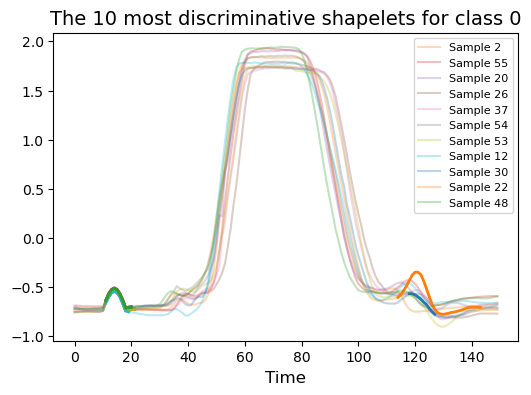

In [415]:
# from pyts.transformation import ShapeletTransform
# st = ShapeletTransform(window_sizes=[8,9,10,20,30],
#                        random_state=42, sort=True)
# X_new = st.fit_transform(test_x.reshape(test_x.shape[0],test_x.shape[-1]), np.argmax(test_y, axis=1))
# test_y_one_hot = np.argmax(test_y, axis=1)
 
plt.figure(figsize=(6, 4))
count = 0
for i, index in enumerate(st.indices_):
    idx, start, end = index
    if count > 10:
        break
    if test_y_one_hot[idx] == 0:
        plt.plot(test_x.reshape(test_x.shape[0],test_x.shape[-1])[idx], color='C{}'.format(i),
                 label='Sample {}'.format(idx),alpha=0.3)
        plt.plot(np.arange(start, end), test_x.reshape(test_x.shape[0],test_x.shape[-1])[idx, start:end],
                 lw=2, color='C{}'.format(i))
        count +=1
plt.xlabel('Time', fontsize=12)
plt.title('The 10 most discriminative shapelets for class 0', fontsize=14)
plt.legend(loc='best', fontsize=8)
plt.show()

# 12/07 insert implets into probing

## get implet results

In [335]:
GP_implet_cluster = pickle_load_from_file('figure/GunPoint/attr_None_sample_pred_0/IntegratedGradients//implets_cluster_results.pkl')
# implets
implets = pickle_load_from_file('figure/GunPoint/attr_None_sample_pred_0/IntegratedGradients/implets.pkl')['implets']

In [336]:
cluster_indices = GP_implet_cluster['best_indices_dep']

In [103]:
GP_implet.keys()

dict_keys(['implets', 'num_implets', 'best_k_dep', 'best_indices_dep', 'best_centroids_dep', 'best_k_1d', 'best_indices_1d', 'best_centroids_1d'])

In [327]:
cluster_indices.keys()


dict_keys([0, 1, 2, 3])

In [342]:
from Probe import ShapeletProber

cluster: 0 0 {4, 7, 9, 13, 15, 16, 28, 30, 31, 33, 38, 42, 43, 50, 52, 55, 57, 60, 62, 64, 68, 74, 76, 78, 82, 85, 93, 100, 106, 112}


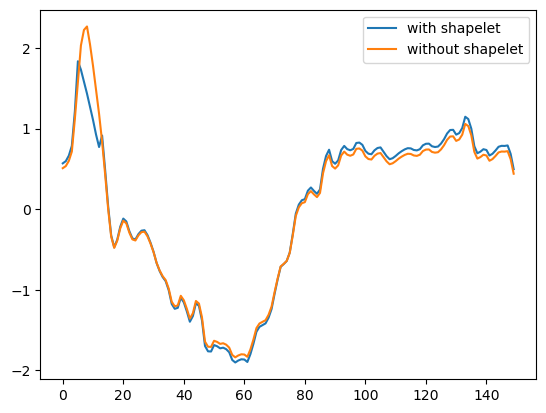

probing training acc: 0.57
probing testing acc: 0.55
original instance acc: 0.31
[0.00102095 0.00102095 0.00102095 0.00102095 0.00102095 0.00102095
 0.00102095 0.00102095 0.00102095 0.00102095]
cluster: 1 1 {3, 6, 8, 14, 21, 27, 29, 32, 34, 35, 37, 41, 48, 49, 51, 54, 61, 63, 67, 73, 77, 79, 80, 81, 84, 86, 90, 92, 98, 105, 111, 116}


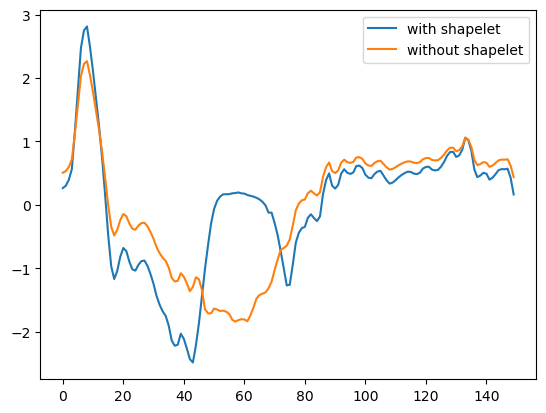

probing training acc: 0.72
probing testing acc: 0.68
original instance acc: 0.59
[-0.05380379 -0.05380379 -0.05380379 -0.05380379 -0.05380379 -0.05380379
 -0.05380379 -0.05380379 -0.05380379 -0.05380379]
cluster: 2 2 {1, 2, 5, 10, 11, 18, 20, 22, 24, 25, 26, 36, 40, 45, 47, 53, 66, 70, 72, 83, 88, 89, 91, 94, 95, 96, 97, 101, 102, 103, 104, 108, 109, 115, 117, 118, 120}


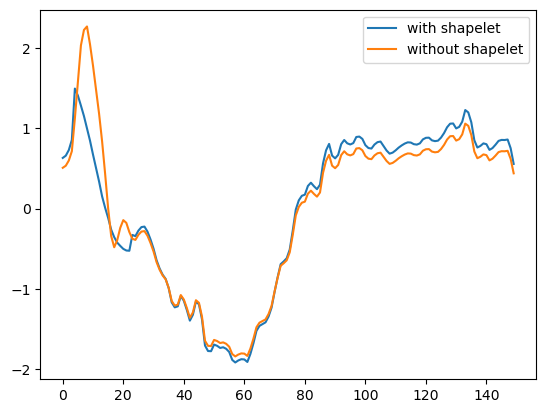

probing training acc: 0.78
probing testing acc: 0.77
original instance acc: 0.39
[0.00864994 0.00864994 0.00864994 0.00864994 0.00864994 0.00864994
 0.00864994 0.00864994 0.00864994 0.00864994]
cluster: 3 3 {0, 12, 17, 19, 23, 39, 44, 46, 56, 58, 59, 65, 69, 71, 75, 87, 99, 107, 110, 113, 114, 119}


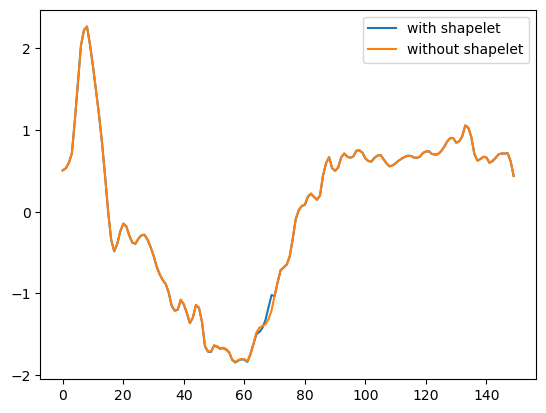

probing training acc: 0.61
probing testing acc: 0.56
original instance acc: 0.80
[0.00277224 0.00277224 0.00277224 0.00277224 0.00277224 0.00277224
 0.00277224 0.00277224 0.00277224 0.00277224]


In [346]:
fc_weight = model.fc.weight[0].clone().cpu().detach().numpy()
fc_weight.shape

for i,(cluster_index, cluster_instance) in enumerate(cluster_indices.items()):
    print(f'cluster: {i}', cluster_index, cluster_instance)
    clsuter_implets = [implets[i][1].flatten() for i in cluster_instance]
    clsuter_implets_instance_number = [implets[i][0] for i in cluster_instance]
    # for impl in clsuter_implets:
    #     plt.plot(impl,color='blue')
    # plt.show()

    selected_datasets = selected_uni
    if 'GunPoint' in selected_datasets:
        selected_datasets.remove('GunPoint')
    # pdata = get_pdata(shapelet=clsuter_implets, selected_datasets=selected_datasets, inst_length=instance_length, 
    #                   num_shapelet=1, is_add=False, repeat_max=100, is_best_insert=True,
    #                   is_z_norm=True, save_dir=f'probe/GunPoint_implet_cluster_1208/cluster{i}/pdata.pkl')


    prober = ShapeletProber(model, device='cuda', save_path=f'probe/GunPoint_implet_cluster_1208/cluster{i}', is_verbose=False)

    pdata = pickle_load_from_file(f'probe/GunPoint_implet_cluster_1208/cluster{i}/pdata.pkl')

    plt.plot(pdata['pdata_ws'][0].flatten(),label='with shapelet')
    plt.plot(pdata['pdata_wos'][0].flatten(),label='without shapelet')
    plt.legend()
    plt.show()
    pdata_shapelet_label = [0]*len(pdata['pdata_ws'])+[1]*len(pdata['pdata_ws'])
    pdata = np.concatenate((pdata['pdata_ws'],pdata['pdata_wos']), axis=0)
    
    test_x_shapelet_label = [
        0 if i in clsuter_implets_instance_number else 1 for i in range(len(test_x))
    ]
    
    results = prober.probe(dataset=test_x, labels=test_y, pdata=pdata, shapelet=None, pos=None, 
                           shapelet_labels=[test_x_shapelet_label,pdata_shapelet_label], 
                           is_threshold_info_gain=False,
                           classifier_type='LR', save_results=True, use_saved_latent=False, merge_latent=False)
    probe_coef = results['classifier'].coef_.flatten()
    train_acc = results['train_acc']
    test_acc =  results['test_acc']
    original_acc = results['accuracy']
    scores = fc_weight @ probe_coef / np.linalg.norm(probe_coef) / np.linalg.norm(c0_grad, axis=1) 
    print(f'probing training acc: {train_acc:.2f}')
    print(f'probing testing acc: {test_acc:.2f}')
    print(f'original instance acc: {original_acc:.2f}')
    print(scores)



In [198]:
print(test_x_shapelet_label)
print(np.argmax(test_y,axis=1))

[1, 1, 1, 1, 0, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 0, 0, 1, 1, 1, 0, 1, 1, 0, 0, 1, 1, 1, 1, 1, 0, 1, 1, 0, 0, 0, 1, 1, 1, 1, 0, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 1, 1, 1, 0, 0, 1, 1, 1, 0, 1, 1, 1, 1, 1, 0, 1, 1, 0, 1, 1, 1, 0, 1, 0, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 0, 1, 1, 0, 1, 0, 1, 0, 1, 1, 1]
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1]


In [209]:
fc_weight = model.fc.weight[0].clone().cpu().detach().numpy()
fc_weight.shape

train_x_sample = train_x[:10]
print(train_x_sample.shape)
c0_grad = get_gradient_from_layers(model, None, train_x_sample,0)

(128,)

(10, 1, 150)


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 155.96it/s]


[0.00939312 0.00939312 0.00939312 0.00939312 0.00939312 0.00939312
 0.00939312 0.00939312 0.00939312 0.00939312]


# 12/08 sanity check random conv layer

In [229]:
model_untrained

FCN(
  (convblock1): ConvBlock(
    (0): Conv1d(1, 128, kernel_size=(7,), stride=(1,), padding=(3,), bias=False)
    (1): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
  )
  (convblock2): ConvBlock(
    (0): Conv1d(128, 256, kernel_size=(5,), stride=(1,), padding=(2,), bias=False)
    (1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
  )
  (convblock3): ConvBlock(
    (0): Conv1d(256, 128, kernel_size=(3,), stride=(1,), padding=(1,), bias=False)
    (1): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
  )
  (gap): GAP1d(
    (gap): AdaptiveAvgPool1d(output_size=1)
    (flatten): Reshape(bs)
  )
  (fc): Linear(in_features=128, out_features=2, bias=True)
)

In [239]:
selected_datasets

['ECG200',
 'Beef',
 'ElectricDevices',
 'Earthquakes',
 'Wafer',
 'PowerCons',
 'NonInvasiveFetalECGThorax1',
 'ECG5000',
 'HandOutlines',
 'CBF',
 'FordA',
 'TwoPatterns',
 'UWaveGestureLibraryAll',
 'Chinatown',
 'Yoga',
 'DistalPhalanxOutlineCorrect',
 'Computers',
 'ShapesAll',
 'Strawberry']

In [ ]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
import torch.nn as nn
# state_dict = torch.load(f'{model_path}/weight.pt',map_location='cuda:1')
# model.load_state_dict(state_dict)
# model.eval()

def initialize_with_seed_for_model(seed, model):
    """
    Initialize all Conv1d layers in a model with the given seed.

    Args:
        seed (int): The random seed for initialization.
        model (nn.Module): The PyTorch model containing Conv1d layers.
    """
    for layer in model.modules():
        if isinstance(layer, nn.Conv1d):
            # Set the seed for reproducibility
            torch.manual_seed(seed)
            # Apply Kaiming Uniform initialization to weights
            nn.init.kaiming_uniform_(layer.weight, nonlinearity='relu')
            # Initialize biases to zero, if present
            if layer.bias is not None:
                nn.init.constant_(layer.bias, 0)
# dataset_train_avg = []
# dataset_train_std = []
# dataset_test_avg = []
# dataset_test_std = []
for dataset in selected_uni:
    train_accs = []
    test_accs = []
    for seed in range(5):
        torch.cuda.manual_seed(seed)
        torch.cuda.manual_seed_all(seed)
        
        
        initialize_with_seed_for_model(seed, model_untrained)
        train_x, test_x, train_y, test_y, enc1 = utils.read_UCR_UEA(dataset, None)
        test_y = np.argmax(test_y, axis=1)
        
        train_y = np.argmax(train_y, axis=1)
        train_x_latent = get_hidden_layers(model_untrained,None,train_x).reshape(train_x.shape[0], -1)
        test_x_latent = get_hidden_layers(model_untrained,None,test_x).reshape(test_x.shape[0], -1)

        model_untrained = FCN(c_in=1, c_out=len(np.unique(test_y)))
        
        classifier = LogisticRegression()
        classifier.fit(train_x_latent, train_y)
        
        pred_train = classifier.predict(train_x_latent)
        pred_test = classifier.predict(test_x_latent)
        
        train_acc = accuracy_score(train_y, pred_train)
        test_acc = accuracy_score(test_y, pred_test)
        
        # print(f"Training Accuracy = {train_acc:.2f}")
        # print(f"Testing Accuracy = {test_acc:.2f}")
        train_accs.append(train_acc)
        test_accs.append(test_acc)
    train_accs = np.array(train_accs)
    test_accs = np.array(test_accs)
    print(dataset)
    print(f'train acc {train_accs.mean():.2f} ± {train_accs.std():.2f}')
    print(f'test acc {test_accs.mean():.2f} ± {test_accs.std():.2f}')
    dataset_train_avg.append(train_accs.mean())
    dataset_train_std.append(train_accs.std())
    dataset_test_avg.append(test_accs.mean())
    dataset_test_std.append(test_accs.std())


In [468]:
df_stat = pd.read_csv('../../CF/df_stat_uni.csv')
df_stat = df_stat[['Name','Class']]

In [ ]:
df_stat

In [473]:
df = pd.DataFrame({'train_avg': dataset_train_avg, 'train_std': dataset_train_std, 'test_avg':dataset_test_avg, 'test_std': dataset_test_std})
df.index = selected_datasets +['GunPoint']
df = df.round(2)
df = df.reset_index()
df = df.merge(df_stat,left_on='index',right_on='Name')
df.drop('Name',axis=1,inplace=True)
df

,index,train_avg,train_std,test_avg,test_std,Class
0,ECG200,0.69,0.00,0.64,0.00,2
1,Beef,0.51,0.04,0.43,0.03,5
2,ElectricDevices,0.74,0.01,0.63,0.01,7
3,Earthquakes,0.82,0.00,0.75,0.00,2
4,Wafer,0.90,0.00,0.89,0.00,2
5,PowerCons,0.80,0.01,0.84,0.00,2
6,NonInvasiveFetalECGThorax1,0.31,0.01,0.26,0.01,42
7,ECG5000,0.91,0.01,0.90,0.00,5
8,HandOutlines,0.66,0.00,0.65,0.00,2
9,CBF,0.45,0.07,0.37,0.05,3


In [464]:
df

,index,train_avg,train_std,test_avg,test_std
0,ECG200,0.69,0.00,0.64,0.00
1,Beef,0.51,0.04,0.43,0.03
2,ElectricDevices,0.74,0.01,0.63,0.01
3,Earthquakes,0.82,0.00,0.75,0.00
4,Wafer,0.90,0.00,0.89,0.00
5,PowerCons,0.80,0.01,0.84,0.00
6,NonInvasiveFetalECGThorax1,0.31,0.01,0.26,0.01
7,ECG5000,0.91,0.01,0.90,0.00
8,HandOutlines,0.66,0.00,0.65,0.00
9,CBF,0.45,0.07,0.37,0.05
